In [395]:
import numpy as np
from importlib import reload
import pandas as pd
import fdc
import tqdm
fdc=reload(fdc)
import matplotlib.pyplot as plt

# REAL DATA

In [349]:
# load the data
sleep_tag = pd.read_csv('../Data_for_analysis/EPCTL06.csv')



In [351]:
sleep_data = np.load('../Data_for_analysis/EPCTL06-prep-001.npy')

In [362]:
sleep_tag['L'].unique()

array(['L', 'W', 'N1', 'N2', 'N3', 'R'], dtype=object)

Primo sample non-'L' è al sample 76800
Questo corrisponde a 600.0 secondi = 10.0 minuti


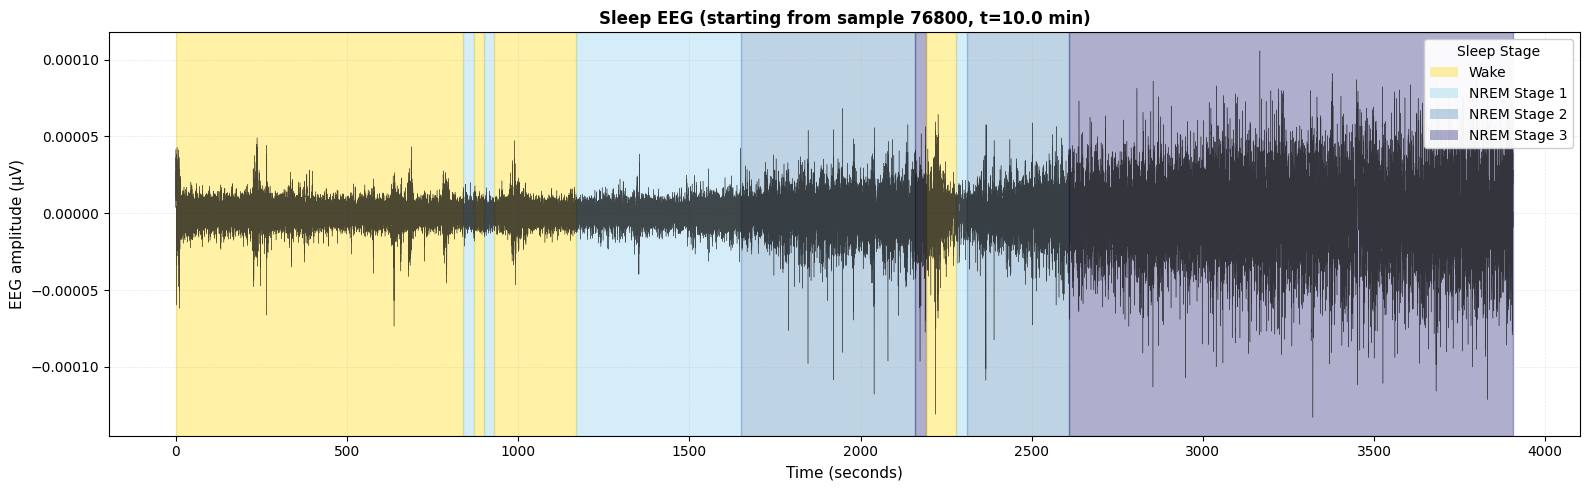


=== STATISTICHE COMPLETE ===
Total recording: 459.0 minutes

Stage distribution (tutta la registrazione):
  Wake                :   73.5 min ( 16.0%)
  NREM Stage 1        :   38.5 min (  8.4%)
  NREM Stage 2        :  187.0 min ( 40.7%)
  NREM Stage 3        :   77.0 min ( 16.8%)
  REM                 :   67.0 min ( 14.6%)
  Latency/Unknown     :   16.0 min (  3.5%)


In [367]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Parametri
fs = 128
samples_per_epoch = fs * 30  # 3840

# Espandi labels
stages = sleep_tag['L'].values
expanded_labels = np.repeat(stages, samples_per_epoch)
n_samples = min(len(expanded_labels), sleep_data.shape[1])
expanded_labels = expanded_labels[:n_samples]

# TROVA DOVE FINISCONO LE 'L' INIZIALI
first_non_L = np.where(expanded_labels != 'L')[0]
if len(first_non_L) > 0:
    start_idx = first_non_L[0]
    print(f"Primo sample non-'L' è al sample {start_idx}")
    print(f"Questo corrisponde a {start_idx/fs:.1f} secondi = {start_idx/fs/60:.1f} minuti")
else:
    start_idx = 0

# PLOT A PARTIRE DAL PRIMO SAMPLE VERO
n_plot = min(500000, n_samples - start_idx)
plot_start = start_idx
plot_end = start_idx + n_plot

time_seconds = np.arange(n_plot) / fs

fig, ax = plt.subplots(figsize=(16, 5))

# Plot serie temporale
ax.plot(time_seconds, sleep_data[0, plot_start:plot_end], 
        'k-', linewidth=0.3, alpha=0.7)

# Colori per sleep stages
stage_colors = {
    'W': '#FFD700',    # Wake - giallo
    'N1': '#87CEEB',   # N1 - azzurro
    'N2': '#4682B4',   # N2 - blu
    'N3': '#191970',   # N3 - blu scuro
    'R': '#FF6347',    # REM - rosso
    'L': '#D3D3D3',    # Latency - grigio
}

# Background colorato
current_stage = expanded_labels[plot_start]
segment_start = 0

for i in range(1, n_plot + 1):
    idx = plot_start + i
    if idx >= plot_end or expanded_labels[idx] != current_stage:
        color = stage_colors.get(current_stage, '#CCCCCC')
        ax.axvspan(segment_start, (i-1)/fs, alpha=0.35, color=color)
        
        if idx < plot_end:
            current_stage = expanded_labels[idx]
            segment_start = i/fs

# Legenda
stage_order = ['W', 'N1', 'N2', 'N3', 'R', 'L']
stage_names = {
    'W': 'Wake',
    'N1': 'NREM Stage 1',
    'N2': 'NREM Stage 2', 
    'N3': 'NREM Stage 3',
    'R': 'REM',
    'L': 'Latency/Unknown'
}

unique_stages = [s for s in stage_order 
                 if s in np.unique(expanded_labels[plot_start:plot_end])]
legend_elements = [
    Patch(facecolor=stage_colors[stage], 
          label=stage_names[stage], 
          alpha=0.35)
    for stage in unique_stages
]
ax.legend(handles=legend_elements, title='Sleep Stage', 
         loc='upper right', framealpha=0.95, fontsize=10)

ax.set_xlabel('Time (seconds)', fontsize=11)
ax.set_ylabel('EEG amplitude (μV)', fontsize=11)
ax.set_title(f'Sleep EEG (starting from sample {start_idx}, t={start_idx/fs/60:.1f} min)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Statistiche complete
print(f"\n=== STATISTICHE COMPLETE ===")
print(f"Total recording: {n_samples/fs/60:.1f} minutes")
print(f"\nStage distribution (tutta la registrazione):")
for stage in stage_order:
    count = np.sum(expanded_labels == stage)
    percentage = count / len(expanded_labels) * 100
    minutes = count / fs / 60
    if count > 0:
        print(f"  {stage_names[stage]:20s}: {minutes:6.1f} min ({percentage:5.1f}%)")

In [447]:
def extract_sleep_stage_segment(sleep_data, sleep_tag, stage_label, segment_number=0, 
                               segment_length=-1, skip_first_epoch=False, fs=128):
    """
    Extract time series corresponding to a specific sleep stage occurrence.
    
    Parameters
    ----------
    sleep_data : np.ndarray, shape (n_channels, n_samples)
        Multi-channel sleep time series data
    sleep_tag : pd.DataFrame
        DataFrame with column 'L' containing sleep stage labels
    stage_label : str
        Sleep stage to extract ('W', 'N1', 'N2', 'N3', 'R', 'L')
    segment_number : int, default=0
        Which occurrence of the stage to extract (0 = first, 1 = second, etc.)
    segment_length : int, default=-1
        Length of the segment to extract in epochs (30 seconds each). 
        If -1, extract the entire segment.
        If positive, extract only the specified number of epochs.
    skip_first_epoch : bool, default=False
        If True, skip the first epoch and start from the second.
        Useful to avoid transition artifacts at stage boundaries.
        If segment_length is specified, extracts epochs 2 to (segment_length+1).
        If not enough epochs are available, falls back to including the first epoch.
    fs : int, default=128
        Sampling frequency in Hz
        
    Returns
    -------
    segment_data : np.ndarray or None
        Time series of the requested segment, shape (n_channels, n_samples_segment)
        Returns None if segment not found
    start_idx : int or None
        Starting sample index of the segment
    end_idx : int or None
        Ending sample index of the segment (exclusive)
    info : dict
        Dictionary with segment information (duration, etc.)
        
    Examples
    --------
    >>> # Extract first N1 segment (complete)
    >>> n1_data, start, end, info = extract_sleep_stage_segment(sleep_data, sleep_tag, 'N1', segment_number=0)
    
    >>> # Extract first 5 epochs (2.5 minutes) of third N2 segment
    >>> n2_data, start, end, info = extract_sleep_stage_segment(sleep_data, sleep_tag, 'N2', segment_number=2, segment_length=5)
    
    >>> # Extract 3 epochs from first N1 segment, skipping first epoch (extracts epochs 2, 3, 4)
    >>> n1_data, start, end, info = extract_sleep_stage_segment(sleep_data, sleep_tag, 'N1', segment_number=0, 
    ...                                                          segment_length=3, skip_first_epoch=True)
    """
    
    # Time parameters
    samples_per_epoch = fs * 30  # 3840 samples per 30-second epoch
    N = sleep_data.shape[0]
    
    # Expand labels to match time series resolution
    stages = sleep_tag['L'].values
    expanded_labels = np.repeat(stages, samples_per_epoch)
    n_samples = min(len(expanded_labels), sleep_data.shape[1])
    expanded_labels = expanded_labels[:n_samples]
    
    # Find all indices with the requested stage
    stage_indices = np.where(expanded_labels == stage_label)[0]
    
    if len(stage_indices) == 0:
        print(f"No samples found for stage '{stage_label}'!")
        return None, None, None, None
    
    # Find consecutive segments
    # A new segment starts when the difference between consecutive indices > 1
    breaks = np.where(np.diff(stage_indices) > 1)[0] + 1
    
    # Split indices into segments
    if len(breaks) > 0:
        segments = np.split(stage_indices, breaks)
    else:
        segments = [stage_indices]
    
    # Check if requested segment exists
    n_segments = len(segments)
    if segment_number >= n_segments:
        print(f"Segment {segment_number} not found! Stage '{stage_label}' has only {n_segments} segment(s).")
        print(f"Valid segment_number values: 0 to {n_segments - 1}")
        return None, None, None, None
    
    # Extract the requested segment
    segment_indices = segments[segment_number]
    segment_start_idx = segment_indices[0]
    segment_end_idx = segment_indices[-1] + 1  # Full segment end
    
    # Calculate available epochs in this segment
    full_n_samples = segment_end_idx - segment_start_idx
    full_n_epochs = full_n_samples // samples_per_epoch
    
    # Determine extraction parameters based on skip_first_epoch and segment_length
    first_epoch_actually_skipped = False
    
    if skip_first_epoch:
        # Check if we can actually skip the first epoch
        if segment_length > 0:
            # Need segment_length + 1 epochs total to skip first and extract segment_length
            epochs_needed = segment_length + 1
            can_skip = full_n_epochs >= epochs_needed
        else:
            # Need at least 2 epochs to skip first
            can_skip = full_n_epochs >= 2
        
        if can_skip:
            # Can skip first epoch as requested
            start_idx = segment_start_idx + samples_per_epoch
            first_epoch_actually_skipped = True
            
            if segment_length > 0:
                end_idx = start_idx + (segment_length * samples_per_epoch)
                n_epochs_extracted = segment_length
                epochs_range = f"epochs 2-{segment_length + 1}"
            else:
                # Extract all remaining epochs after skipping first
                end_idx = segment_end_idx
                n_epochs_extracted = full_n_epochs - 1
                epochs_range = f"epochs 2-{full_n_epochs}"
        else:
            # FALLBACK: Not enough epochs to skip, include first epoch
            print(f"  Warning: Requested skip_first_epoch=True, but segment has only {full_n_epochs} epoch(s).")
            print(f"           Falling back to including first epoch.")
            
            start_idx = segment_start_idx
            
            if segment_length > 0:
                if segment_length > full_n_epochs:
                    # Extract all available
                    end_idx = segment_end_idx
                    n_epochs_extracted = full_n_epochs
                else:
                    end_idx = start_idx + (segment_length * samples_per_epoch)
                    n_epochs_extracted = segment_length
                epochs_range = f"epochs 1-{n_epochs_extracted}"
            else:
                # Extract entire segment
                end_idx = segment_end_idx
                n_epochs_extracted = full_n_epochs
                epochs_range = f"epochs 1-{full_n_epochs}"
    
    else:
        # Start from first epoch (no skip)
        start_idx = segment_start_idx
        
        if segment_length > 0:
            if segment_length > full_n_epochs:
                print(f"  Warning: Requested {segment_length} epochs, but segment only has {full_n_epochs} epochs.")
                print(f"           Extracting all {full_n_epochs} available epochs.")
                end_idx = segment_end_idx
                n_epochs_extracted = full_n_epochs
            else:
                end_idx = start_idx + (segment_length * samples_per_epoch)
                n_epochs_extracted = segment_length
            epochs_range = f"epochs 1-{n_epochs_extracted}"
        else:
            # Extract entire segment
            end_idx = segment_end_idx
            n_epochs_extracted = full_n_epochs
            epochs_range = f"epochs 1-{full_n_epochs}"
    
    # Extract the data
    segment_data = sleep_data[:, start_idx:end_idx]
    
    # Calculate segment information
    n_samples_segment = end_idx - start_idx
    duration_seconds = n_samples_segment / fs
    duration_minutes = duration_seconds / 60
    
    info = {
        'stage': stage_label,
        'segment_number': segment_number,
        'total_segments': n_segments,
        'start_idx': start_idx,
        'end_idx': end_idx,
        'n_samples': n_samples_segment,
        'n_epochs': n_epochs_extracted,
        'full_segment_epochs': full_n_epochs,
        'duration_seconds': duration_seconds,
        'duration_minutes': duration_minutes,
        'n_channels': N,
        'sampling_frequency': fs,
        'truncated': segment_length > 0 and segment_length < full_n_epochs,
        'first_epoch_skipped': first_epoch_actually_skipped,
        'skip_requested': skip_first_epoch,
        'epochs_range': epochs_range
    }
    
    # Print information
    print(f"Stage '{stage_label}' - Segment {segment_number + 1}/{n_segments}:")
    print(f"  Full segment epochs: {full_n_epochs}")
    print(f"  Extracted: {epochs_range} ({n_epochs_extracted} epochs)")
    if skip_first_epoch:
        if first_epoch_actually_skipped:
            print(f"  First epoch skipped: Yes ✓")
        else:
            print(f"  First epoch skipped: No (fallback - not enough epochs)")
    print(f"  Start index: {start_idx}")
    print(f"  End index: {end_idx}")
    print(f"  Number of samples: {n_samples_segment}")
    print(f"  Duration: {duration_seconds:.2f} seconds = {duration_minutes:.2f} minutes")
    print(f"  Shape of extracted time series: {segment_data.shape}")
    
    return segment_data, start_idx, end_idx, info

In [443]:

# Helper function to list all available segments
def list_sleep_stage_segments(sleep_data, sleep_tag, stage_label, fs=128):
    """
    List all consecutive segments of a given sleep stage.
    
    Parameters
    ----------
    sleep_data : np.ndarray
        Sleep time series data
    sleep_tag : pd.DataFrame
        Sleep stage labels
    stage_label : str
        Sleep stage to analyze
    fs : int, default=128
        Sampling frequency
        
    Returns
    -------
    segments_info : list of dict
        List of dictionaries containing info about each segment
    """
    
    samples_per_epoch = fs * 30
    stages = sleep_tag['L'].values
    expanded_labels = np.repeat(stages, samples_per_epoch)
    n_samples = min(len(expanded_labels), sleep_data.shape[1])
    expanded_labels = expanded_labels[:n_samples]
    
    stage_indices = np.where(expanded_labels == stage_label)[0]
    
    if len(stage_indices) == 0:
        print(f"No samples found for stage '{stage_label}'!")
        return []
    
    breaks = np.where(np.diff(stage_indices) > 1)[0] + 1
    segments = np.split(stage_indices, breaks) if len(breaks) > 0 else [stage_indices]
    
    segments_info = []
    print(f"\nStage '{stage_label}' has {len(segments)} consecutive segment(s):\n")
    
    for i, seg_indices in enumerate(segments):
        start_idx = seg_indices[0]
        end_idx = seg_indices[-1] + 1
        n_samples_seg = end_idx - start_idx
        duration_sec = n_samples_seg / fs
        duration_min = duration_sec / 60
        
        info = {
            'segment_number': i,
            'start_idx': start_idx,
            'end_idx': end_idx,
            'n_samples': n_samples_seg,
            'duration_seconds': duration_sec,
            'duration_minutes': duration_min,
            'start_time_minutes': start_idx / fs / 60
        }
        
        segments_info.append(info)
        
        print(f"  Segment {i}:")
        print(f"    Time: {info['start_time_minutes']:.2f} - {(end_idx/fs/60):.2f} minutes")
        print(f"    Indices: {start_idx} - {end_idx}")
        print(f"    Duration: {duration_sec:.2f} s ({duration_min:.2f} min)")
        print(f"    Samples: {n_samples_seg}\n")
    
    return segments_info

In [ ]:
C_freq = np.zeros((x.shape[0], x.shape[0], len(freqs)), dtype=complex)
S_ii = []

freqs = np.logspace(-2, 1, 500)
for i, f in enumerate(tqdm.tqdm(freqs, desc="Computing FDC", unit="freq")):
    #x= generate_OU(W, T, dt, g=g/np.sqrt(1+ (f)**2))
    cif = fdc.correlation_freq(
        x,
        time_step=dt,
        frequency=f,
        n_chunks=50,          # important for unbiased estimator
        corr_type="covariance"
    )
    C_freq[:, :, i] = cif
    S_ii.append(np.mean(np.diag(cif)))



Computing FDC: 100%|██████████| 500/500 [01:03<00:00,  7.88freq/s]


In [448]:
# Extract first N1 segment (complet
n1_timeseries, start, end, info = extract_sleep_stage_segment(sleep_data, 
                                                              sleep_tag, 
                                                              'N1', 
                                                              segment_number=2, 
                                                              segment_length=2,
                                                              skip_first_epoch=True)
    

Stage 'N1' - Segment 3/27:
  Full segment epochs: 16
  Extracted: epochs 2-3 (2 epochs)
  First epoch skipped: Yes ✓
  Start index: 230400
  End index: 238080
  Number of samples: 7680
  Duration: 60.00 seconds = 1.00 minutes
  Shape of extracted time series: (83, 7680)


In [407]:
#from sleep_stage_function import *

# Esempio 2: Estrai il secondo segmento N3
n3_timeseries, start, end, info = extract_sleep_stage_segment(
    sleep_data, sleep_tag, 'N3', segment_number=1, fs=128
)


Stage 'N3' - Segment 2/16:
  Start index: 410880
  End index: 614400
  Number of samples: 203520
  Duration: 1590.00 seconds = 26.50 minutes
  Shape of extracted time series: (83, 203520)


In [ ]:
# Frequenze da analizzare 
freqs = np.linspace(0.5, 45, 500)  # Frequencies from 0.5 to 30 Hz
#freqs = np.linspace(2, 15, 100)  # Da delta a beta basso
omegas = 2 * np.pi * freqs

# Calcola FDC matrix per il segmento n1
import tqdm

C_freq_n1 = np.zeros((n1_timeseries.shape[0], n1_timeseries.shape[0], len(freqs)), dtype=complex)
S_ii = []

for i, f in enumerate(tqdm.tqdm(freqs, desc="Computing FDC for n1")):
    cif = fdc.correlation_freq(
        n1_timeseries,
        time_step=1/fs,
        frequency=f, # in hertz
        n_chunks=50,
        corr_type="covariance"
    )
    C_freq_n1[:, :, i] = cif
    S_ii.append(np.mean(np.diag(cif)))


Computing FDC for n1: 100%|██████████| 500/500 [00:09<00:00, 55.33it/s]


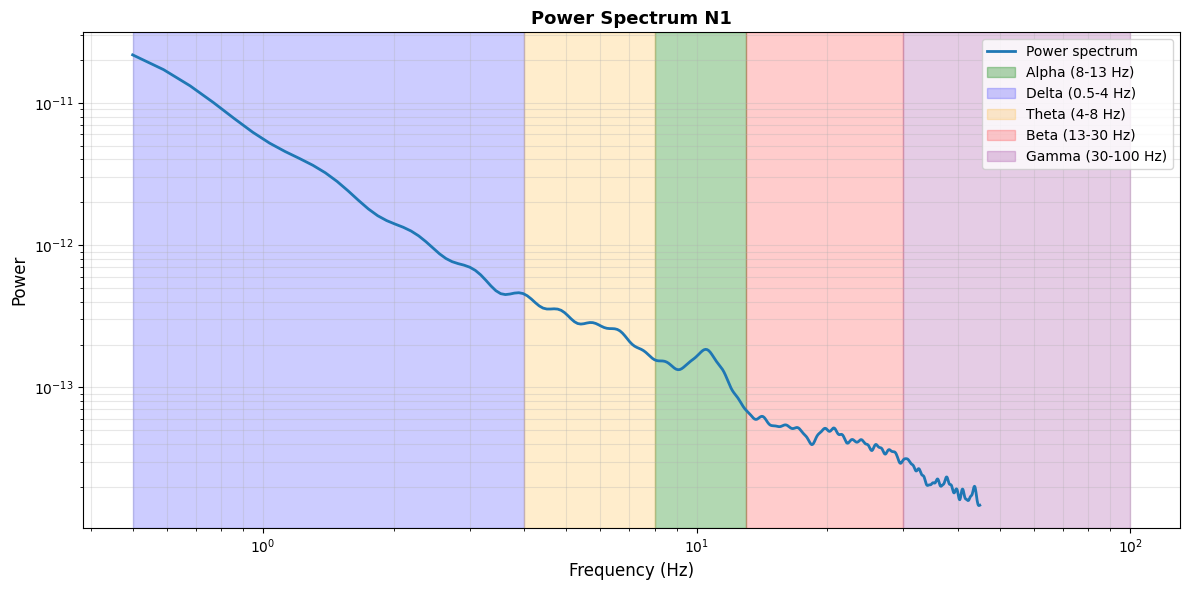

In [431]:
plt.figure(figsize=(12, 6))
plt.loglog(freqs, S_ii, linewidth=2, label='Power spectrum')

# Barre verticali per alpha band (8-13 Hz)
plt.axvspan(8, 13, alpha=0.3, color='green', label='Alpha (8-13 Hz)')

# Opzionale: aggiungi anche altre bande
plt.axvspan(0.5, 4, alpha=0.2, color='blue', label='Delta (0.5-4 Hz)')
plt.axvspan(4, 8, alpha=0.2, color='orange', label='Theta (4-8 Hz)')
plt.axvspan(13, 30, alpha=0.2, color='red', label='Beta (13-30 Hz)')
plt.axvspan(30, 100, alpha=0.2, color='purple', label='Gamma (30-100 Hz)')

plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('Power Spectrum N1', fontsize=13, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.savefig('power_spectrum_with_bands.png')
plt.show()

## Select a chunk of each of the 4 sleep phases and compare the 4 power spectrum

In [453]:
selected_timeseries = {}
freqs = np.linspace(0.3, 45, 1000)  # Frequencies from 0.3 to 45 Hz

C_freqs_dict = {}
S_ii_dict = {}

for stage in ['W', 'N1', 'N2', 'N3', 'R']:

    timeseries, start, end, info = extract_sleep_stage_segment(
        sleep_data, sleep_tag, stage, segment_number=0, segment_length=-1, skip_first_epoch=True, fs=fs
        )
    selected_timeseries[stage] = timeseries

    C_freq = np.zeros((timeseries.shape[0], timeseries.shape[0], len(freqs)), dtype=complex)
    S_ii = []
    
    for i, f in enumerate(tqdm.tqdm(freqs, desc=f"Computing FDC for {stage}")):
        cif = fdc.correlation_freq(
            timeseries,
            time_step=1/fs,
            frequency=f, # in hertz
            n_chunks=50,
            corr_type="covariance"
        )
        C_freq[:, :, i] = cif
        S_ii.append(np.mean(np.diag(cif)))

    C_freqs_dict[stage] = C_freq
    S_ii_dict[stage] = S_ii

    

Stage 'W' - Segment 1/22:
  Full segment epochs: 28
  Extracted: epochs 2-28 (27 epochs)
  First epoch skipped: Yes ✓
  Start index: 80640
  End index: 184320
  Number of samples: 103680
  Duration: 810.00 seconds = 13.50 minutes
  Shape of extracted time series: (83, 103680)


Computing FDC for W: 100%|██████████| 1000/1000 [02:05<00:00,  7.99it/s]


           Falling back to including first epoch.
Stage 'N1' - Segment 1/27:
  Full segment epochs: 1
  Extracted: epochs 1-1 (1 epochs)
  First epoch skipped: No (fallback - not enough epochs)
  Start index: 184320
  End index: 188160
  Number of samples: 3840
  Duration: 30.00 seconds = 0.50 minutes
  Shape of extracted time series: (83, 3840)


Computing FDC for N1: 100%|██████████| 1000/1000 [00:14<00:00, 68.30it/s]


Stage 'N2' - Segment 1/32:
  Full segment epochs: 17
  Extracted: epochs 2-17 (16 epochs)
  First epoch skipped: Yes ✓
  Start index: 291840
  End index: 353280
  Number of samples: 61440
  Duration: 480.00 seconds = 8.00 minutes
  Shape of extracted time series: (83, 61440)


Computing FDC for N2: 100%|██████████| 1000/1000 [01:12<00:00, 13.85it/s]


           Falling back to including first epoch.
Stage 'N3' - Segment 1/16:
  Full segment epochs: 1
  Extracted: epochs 1-1 (1 epochs)
  First epoch skipped: No (fallback - not enough epochs)
  Start index: 353280
  End index: 357120
  Number of samples: 3840
  Duration: 30.00 seconds = 0.50 minutes
  Shape of extracted time series: (83, 3840)


Computing FDC for N3: 100%|██████████| 1000/1000 [00:14<00:00, 67.84it/s]


Stage 'R' - Segment 1/3:
  Full segment epochs: 22
  Extracted: epochs 2-22 (21 epochs)
  First epoch skipped: Yes ✓
  Start index: 1240320
  End index: 1320960
  Number of samples: 80640
  Duration: 630.00 seconds = 10.50 minutes
  Shape of extracted time series: (83, 80640)


Computing FDC for R: 100%|██████████| 1000/1000 [01:30<00:00, 11.00it/s]


### baseline 

In [ ]:
from fdc import reshuffling
C_freqs_shuff = {}
S_ii_shuff = {}

for stage in ['W', 'N1', 'N2', 'N3', 'R']:
    reshuffled_ts = reshuffling(selected_timeseries[stage])
    C_freq = np.zeros((reshuffled_ts.shape[0], reshuffled_ts.shape[0], len(freqs)), dtype=complex)
    S_ii = []
    
    for i, f in enumerate(tqdm.tqdm(freqs, desc=f"Computing FDC for {stage}")):
        cif = fdc.correlation_freq(
            reshuffled_ts,
            time_step=1/fs,
            frequency=f, # in hertz
            n_chunks=50,
            corr_type="covariance"
        )
        C_freq[:, :, i] = cif
        S_ii.append(np.mean(np.diag(cif)))

    C_freqs_shuff[stage] = C_freq
    S_ii_shuff[stage] = S_ii

Computing FDC for W:  81%|████████▏ | 813/1000 [01:42<00:23,  7.85it/s]

/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


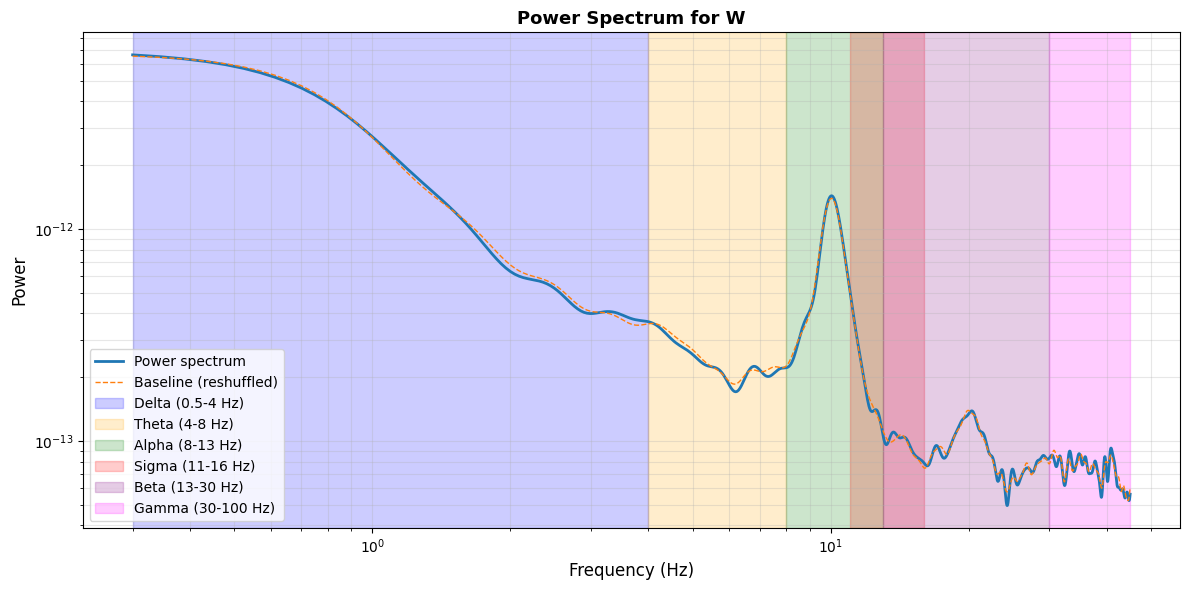

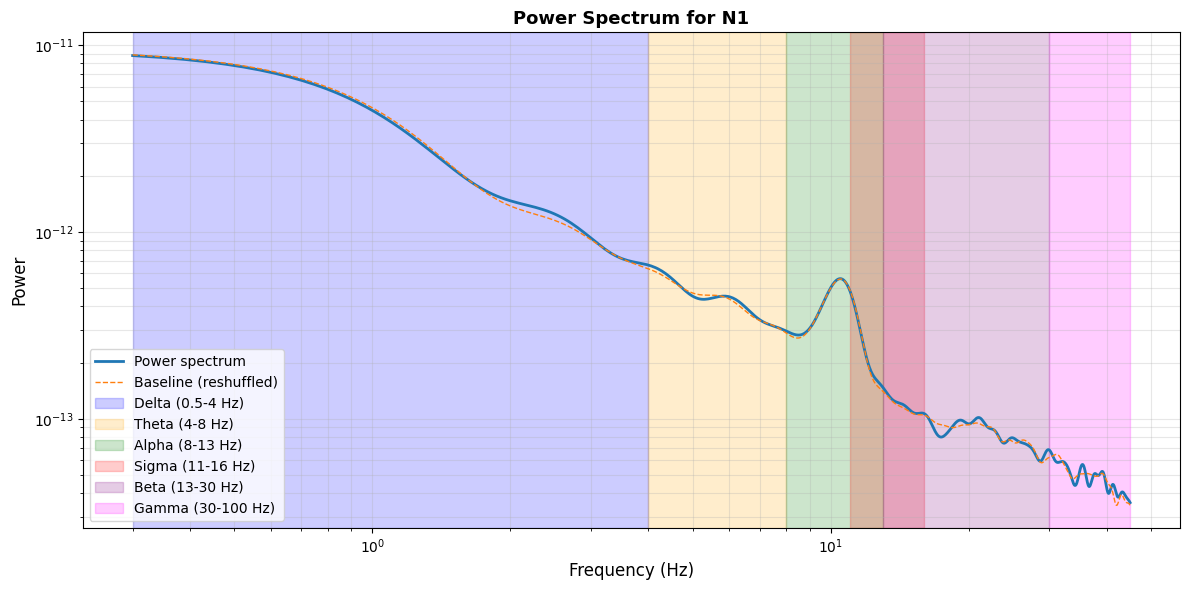

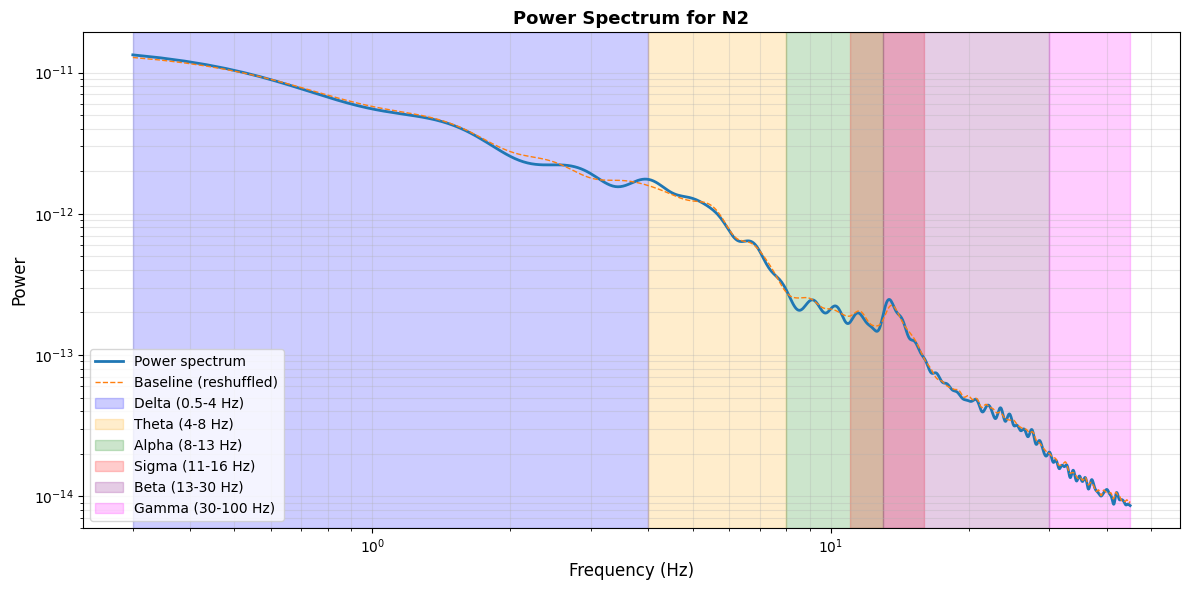

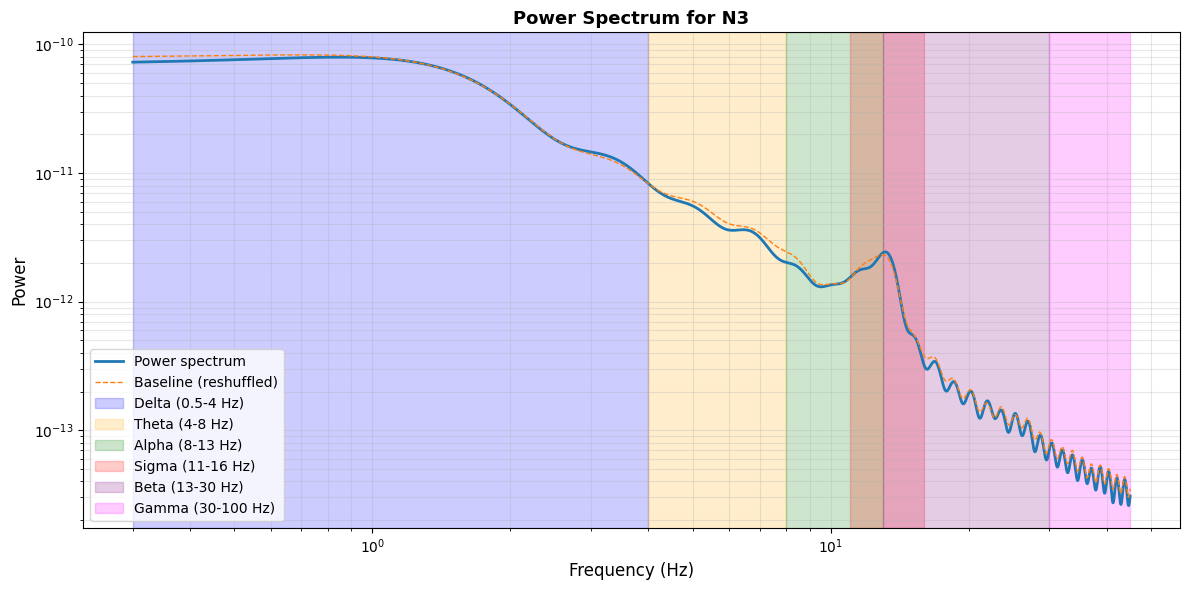

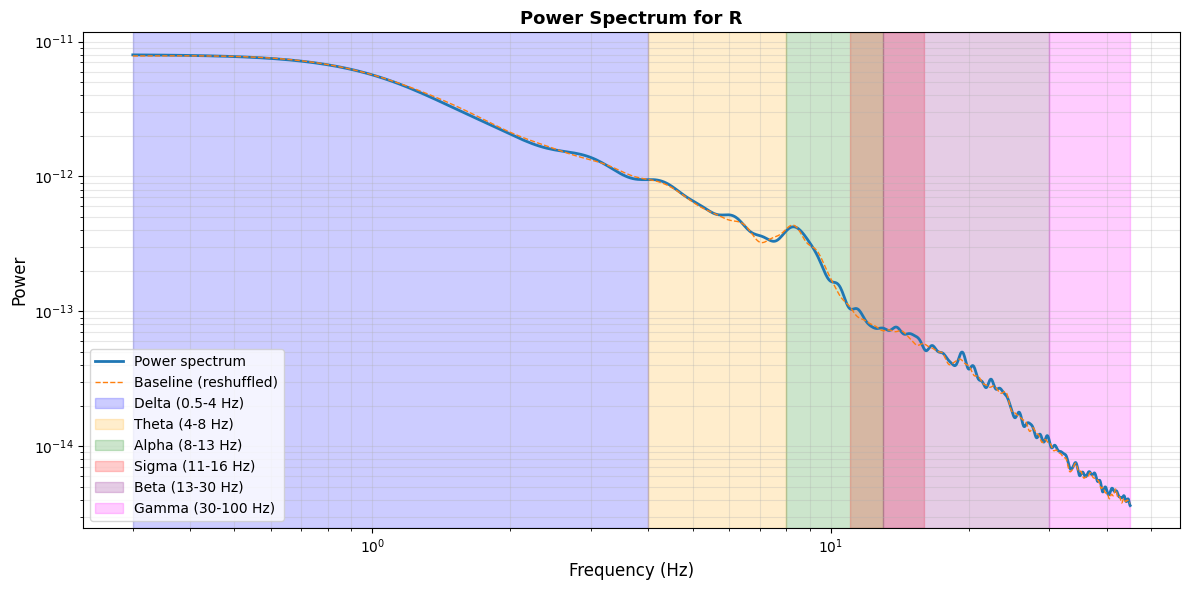

In [ ]:
for stage in S_ii_dict.keys():
    plt.figure(figsize=(12, 6))
    plt.loglog(freqs, S_ii_dict[stage], linewidth=2, label='Power spectrum')
    plt.loglog(freqs, S_ii_shuff[stage], linewidth=1, linestyle='--', label='Baseline (reshuffled)')

    # Barre verticali per alpha band (8-13 Hz)
   

    # Opzionale: aggiungi anche altre bande
    plt.axvspan(0.3, 4, alpha=0.2, color='blue', label='Delta (0.5-4 Hz)')
    plt.axvspan(4, 8, alpha=0.2, color='orange', label='Theta (4-8 Hz)')
    plt.axvspan(8, 13, alpha=0.2, color='green', label='Alpha (8-13 Hz)')
    plt.axvspan(11, 16, alpha=0.2, color='red', label='Sigma (11-16 Hz)')
    plt.axvspan(13, 30, alpha=0.2, color='purple', label='Beta (13-30 Hz)')
    plt.axvspan(30, 45, alpha=0.2, color='magenta', label='Gamma (30-100 Hz)')

    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Power', fontsize=12)
    plt.title(f'Power Spectrum for {stage}', fontsize=13, fontweight='bold')
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3, which='both')
    plt.tight_layout()
    plt.savefig(f'power_spectrum_with_bands_{stage}.png')
    plt.show()

# Simple random process with coupled Oersten-Uhlembeck 

In [ ]:
N = 83
x = np.random.randn(N, 1000) / np.sqrt(N)
np.shape(np.triu(x))

(83, 1000)

In [ ]:
time_step = 1
frequency = 250
n_chunks = 1

In [ ]:
s = fdc.correlation_freq(x,time_step,frequency)

In [ ]:
np.shape(s) #matrixe di correlazione integrate

(83, 83)

In [ ]:
np.mean(np.diag(s).real)

np.float64(1.4264426352603729e-05)

In [ ]:
sii = []
for freq in np.linspace(1,50,1000):
    s = fdc.correlation_freq(x,time_step,freq)
    smean = np.mean(np.diag(s).real)
    #print(smean)
    sii.append(smean)
    

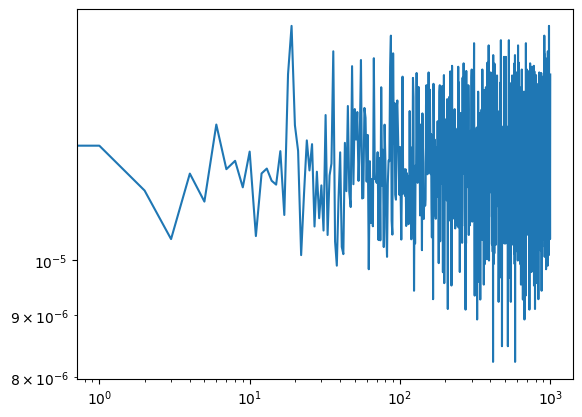

In [ ]:
plt.plot(sii)
plt.xscale('log')
plt.yscale('log')


In [ ]:
def generate_OU(J, T=20000, dt=1, sigma=1.0, g=None):
    """
    Generate multivariate Ornstein-Uhlenbeck (OU) process.
    
    Parameters
    ----------
    N : number of nodes
    T : number of time points
    dt : timestep in seconds
    g : global coupling (scales J)
    sigma : noise amplitude

    Returns
    -------
    X : array shape (N, T)
        OU time series ready to use with correlation_freq()
    """
    # Random Gaussian connectivity (consistent with the paper's theory)

    N = len(J)

    if g == None:
        lambdamax = np.max(np.linalg.eigvals(J))
        g = 1/lambdamax - 0.1
    
    X = np.zeros((N, T))
    noise_scale = np.sqrt(sigma * dt)

    for t in range(T-1):
        drift = (-X[:, t] + g * J @ X[:, t])
        noise = noise_scale * np.random.randn(N) 
        X[:, t+1] = X[:, t] + dt * drift + noise

    # Removing transient (optional)
    return X#[:, 5000:]   # discard first 5k samples


In [ ]:
def generate_OU(J, T=20000, dt=0.01, sigma=1.0, g=None, burn_in=0):
    """
    Generate multivariate Ornstein-Uhlenbeck (OU) process.
    
    Implements:
        dx_i/dt = -x_i + g * sum_j J_ij * x_j + sigma * xi_i(t)
    
    where xi_i(t) is white noise with <xi_i(t)xi_j(s)> = delta_ij * delta(t-s)
    
    Parameters
    ----------
    J : np.ndarray, shape (N, N)
        Connectivity matrix
    T : int
        Number of time points
    dt : float
        Time step (in seconds). Default: 0.01
    sigma : float
        Noise amplitude. Default: 1.0
    g : float, optional
        Global coupling strength (scales J).
        If None, sets g = 1/lambda_max - 0.1 (near critical)
    burn_in : int
        Number of initial time steps to discard (transient removal)
        
    Returns
    -------
    X : np.ndarray, shape (N, T - burn_in)
        OU time series ready to use with correlation_freq()
    """
    N = len(J)
    
    # Set coupling strength
    if g is None:
        # Near the edge of instability
        lambdamax = np.max(np.real(np.linalg.eigvals(J)))
        g = 1.0 / lambdamax - 0.1
        print(f"Auto-setting g = {g:.4f} (lambda_max = {lambdamax:.4f})")
    
    # Initialize
    X = np.zeros((N, T))
    X[:, 0] = np.random.randn(N) * 0.1  # Small random initial condition
    
    # Euler-Maruyama integration
    noise_scale = sigma * np.sqrt(dt)  
    
    for t in range(T - 1):
        # Deterministic part
        drift = -X[:, t] + g * (J @ X[:, t])
        
        # Stochastic part
        noise = noise_scale * np.random.randn(N)
        
        # Update
        X[:, t + 1] = X[:, t] + dt * drift + noise
    
    # Remove transient if requested
    if burn_in > 0:
        return X[:, burn_in:]
    
    return X

## random example

In [ ]:
N = 83
A = np.random.randn(N, N) / np.sqrt(N)
J = (A + A.T) / 2

In [ ]:
tp = 128
T = tp*30
dt=1/tp
x = generate_OU(J, T, dt, sigma=2, g=None)

Auto-setting g = 0.6218 (lambda_max = 1.3853)


In [ ]:
N

80

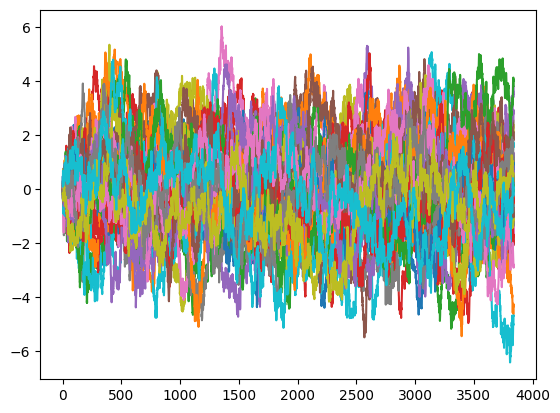

In [ ]:
plt.plot(x.T);

In [ ]:
np.shape(x)

(40, 3840)

In [ ]:
x.shape = (N, T)   # Your OU data
dt  

ValueError: cannot reshape array of size 153600 into shape (80,3840)

In [ ]:
freqs = np.linspace(0.0001, 100, 1000) #np.logspace(-3, 2., 50)  
omegas = 2 * np.pi * freqs

In [ ]:
C_freq = np.zeros((N, N, len(freqs)), dtype=complex)
S_ii = []

for i, f in enumerate(freqs):
    cif = fdc.correlation_freq(
        x,
        time_step=dt,
        frequency=f,
        n_chunks=10,          # important for unbiased estimator
        corr_type="covariance"
    )
    C_freq[:, :, i] = cif
    S_ii.append(np.mean(np.diag(cif)))


/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


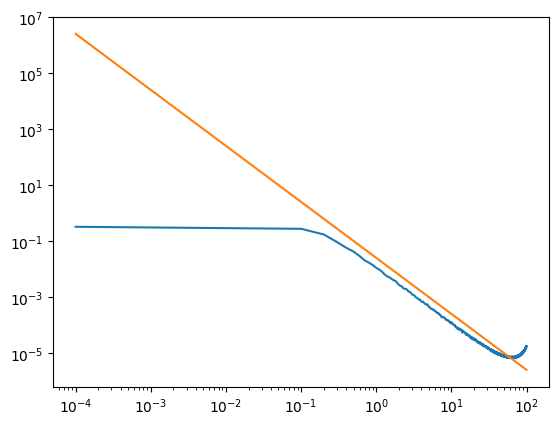

In [ ]:
plt.loglog(freqs,S_ii)
plt.plot(freqs,1/omegas**2)
#plt.xlim(10e0,10)

# Block diagonal case 

In [ ]:
N = 80

tp = 128
T = tp * 1000  # = 12800 time steps (~100 s con dt=1/128)
dt = 1/tp
burn_in = tp * 100  # Rimuovi transiente

sigma = 1

#freqs = np.linspace(1e-3, 100, 1000) #
freqs = np.logspace(-3, 1, 1000)  
omegas = 2 * np.pi * freqs


A = np.random.randn(int(N/2), int(N/2)) / np.sqrt(int(N/2))
J = (A + A.T) / 2
#J = J - np.diag(np.diag(J))  # remove self-connections
alpha = 1

if alpha < 1: 
    g = 1/(2*alpha) - 0.1
else:
    g = 1/(2*alpha) -0.1
beta = 5

print("g:", g)


omega_peak = 2 * beta * g / alpha  # In rad/s
f_peak = omega_peak / (2 * np.pi)  # In Hz

print("f_peak (Hz):", f_peak)   

W = np.block([
        [ alpha * J,  -beta * J ],
        [ beta  * J,   alpha * J ]
    ])

# generate process
x = generate_OU(W, T, dt, sigma=sigma, g=g, burn_in=burn_in)

g: 0.4
f_peak (Hz): 0.6366197723675814


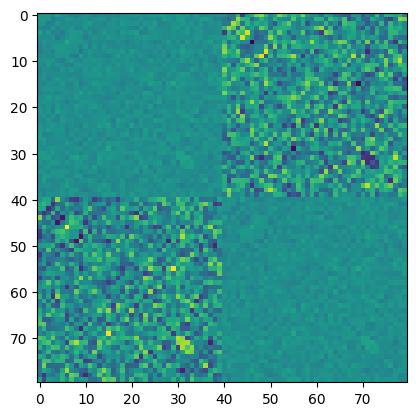

In [ ]:
plt.imshow(W)

In [ ]:
C_freq = np.zeros((N, N, len(freqs)), dtype=complex)
S_ii = []

for i, f in enumerate(freqs):
    cif = fdc.correlation_freq(
        x,
        time_step=dt,
        frequency=f,
        n_chunks=10,          # important for unbiased estimator
        corr_type="covariance"
    )
    C_freq[:, :, i] = cif
    S_ii.append(np.mean(np.diag(cif)))


KeyboardInterrupt: 

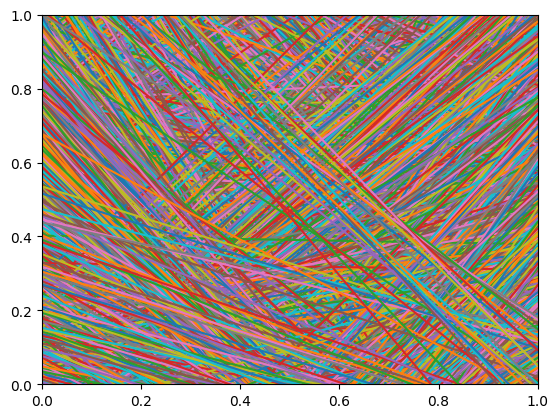

In [ ]:
plt.plot(x)
plt.show()

/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


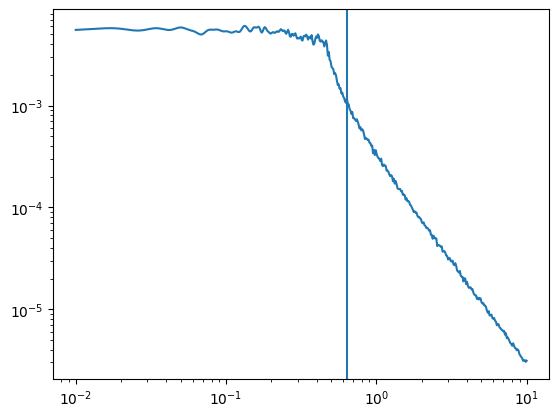

In [ ]:
plt.loglog(freqs,S_ii)
#plt.plot(freqs,1/omegas**2*10e12) 
plt.axvline(f_peak)

In [ ]:
np.argmax(S_ii)

np.int64(197)

In [ ]:
freqs[np.argmax(S_ii)]

np.float64(0.15288635880587303)

In [ ]:
beta/(alpha)

5.0

In [ ]:
g

0.4

In [ ]:
2*g*beta/alpha

4.0